In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import mse as sm_mse, rmse as sm_rmse, meanabs as sm_mae
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, TFT, PatchTST, TCN, DLinear, RNN, LSTM, Autoformer, BiTCN, DeepAR, DeepNPTS, DilatedRNN, FEDformer, GRU, HINT, Informer, iTransformer, KAN, MLP, MLPMultivariate, NBEATSx, NLinear, RMoK, SOFTS, StemGNN, TiDE, TimeMixer, TimeLLM, TimesNet, TSMixer, TSMixerx, VanillaTransformer
from neuralforecast.losses.pytorch import MQLoss, MAE

from neuralforecast.utils import AirPassengersDF
import time
import torch
torch.set_float32_matmul_precision('high')  # or 'medium' for more precision
import plotly.express as px
import plotly.graph_objects as go
from sklearn.utils import check_random_state
import logging
logging.basicConfig(level=logging.INFO)
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random_state = check_random_state(seed)

In [2]:
# Re-load the dataset (user needs to re-upload the file)
df = pd.read_csv(f"../data/Top_12_German_Companies_Financial_Data.csv") # Load the dataset

# Filter dataset for SAP SE only
sap_df = df[df["Company"] == "SAP SE"].copy()

# Convert Period column to datetime format
sap_df["Period"] = pd.to_datetime(sap_df["Period"], format="%m/%d/%Y")

# Sort data by Period for proper time-series analysis
sap_df = sap_df.sort_values(by="Period")

# Convert revenue to numeric
sap_df["Revenue"] = pd.to_numeric(sap_df["Revenue"], errors="coerce")
sap_df= sap_df[["Revenue", 'Period']]

In [3]:
# Convert 'Year' column to datetime if it's not already
sap_df['ds'] = pd.to_datetime(sap_df['Period'], format='%Y')
sap_df['unique_id'] = "all"
sap_df = sap_df.rename(columns={"Revenue": "y"}) 
sap_df = sap_df[["unique_id", "ds", "y"]] 

<Axes: title={'center': 'SAP SE Revenue Over Time'}>

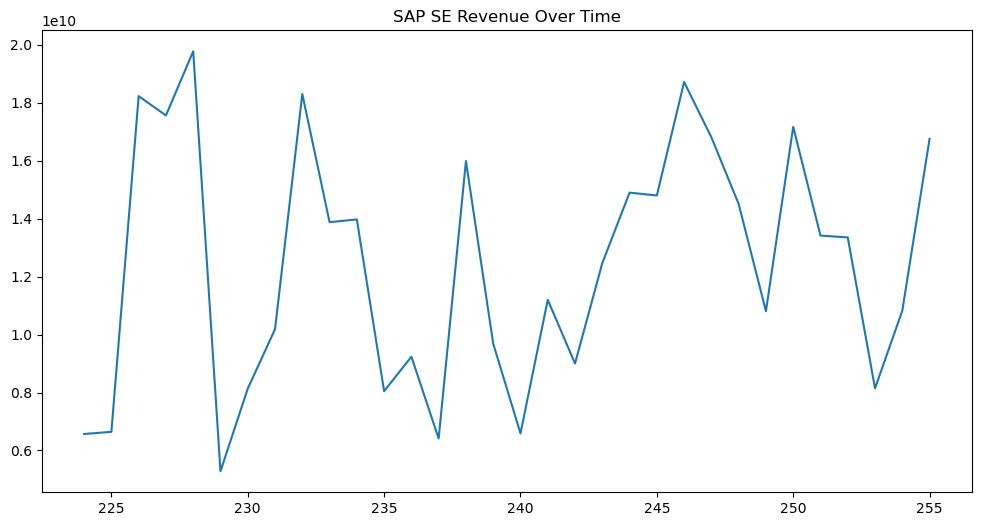

In [4]:
sap_df["y"].plot(figsize=(12, 6), title="SAP SE Revenue Over Time")

In [5]:
sap_df.head()

,unique_id,ds,y
224,all,2017-03-31,6568715630
225,all,2017-06-30,6644029236
226,all,2017-09-30,18227487487
227,all,2017-12-31,17560385805
228,all,2018-03-31,19774628627


In [6]:
# Initialize Scaler
scaler = MinMaxScaler()

In [7]:
# Train-test split
test_size = int(len(sap_df) * 0.2)
train = sap_df[:len(sap_df) - test_size]
val = sap_df[len(sap_df) - test_size:]

In [8]:
# Fit on Training Data & Transform Both Train & Test
df_train_scaled = train.copy()
df_test_scaled = val.copy()

df_train_scaled['y'] = scaler.fit_transform(train[['y']])
df_test_scaled['y'] = scaler.transform(val[['y']])  # Apply same transformation to test set

In [9]:
# Confirm split integrity
print(f"Data split: Total: {len(sap_df)}, Train: {len(train)}, Test: {len(val)}")
print("Training set date range:", train['ds'].min(), "to", train['ds'].max())
print("Testing set date range:", val['ds'].min(), "to", val['ds'].max())
train.set_index('ds', inplace=False)
val.set_index('ds', inplace=False)

Data split: Total: 32, Train: 26, Test: 6
Training set date range: 2017-03-31 00:00:00 to 2023-06-30 00:00:00
Testing set date range: 2023-09-30 00:00:00 to 2024-12-31 00:00:00


,unique_id,y
ds,,
2023-09-30,all,17167661800
2023-12-31,all,13414872686
2024-03-31,all,13351789947
2024-06-30,all,8144018454
2024-09-30,all,10824151396
2024-12-31,all,16754700510


In [10]:
sap_df.head()

,unique_id,ds,y
224,all,2017-03-31,6568715630
225,all,2017-06-30,6644029236
226,all,2017-09-30,18227487487
227,all,2017-12-31,17560385805
228,all,2018-03-31,19774628627


In [11]:

# Custom SMAPE function
def smape_loss(y_true, y_pred):
    y_true = y_true.values
    y_pred = y_pred.values
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Function to evaluate models (Now includes MASE from statsmodels)
def evaluate_model(y_true, y_pred, y_train, model_name, start_time):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = smape_loss(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Compute MASE using statsmodels mean absolute error
    naive_forecast_errors = np.abs(y_train.diff()).dropna()
    mae_naive = sm_mae(naive_forecast_errors, np.zeros_like(naive_forecast_errors))  # Naïve MAE
    mase = sm_mae(y_true, y_pred) / mae_naive if mae_naive != 0 else np.nan  # Avoid division by zero

    runtime = time.time() - start_time

    return {
        "Model": model_name,
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "SMAPE": smape,
        "MASE": mase,  # Now using established library
        "R2 Score": r2,
        "Time (s)": runtime
    }


In [12]:
results = []
input_size=12
models = [
    # ✅ Best models for univariate forecasting
    NBEATS(h=12, input_size=input_size, loss=MAE(), alias='NBEATS_12'),  # Strong for univariate
    NHITS(h=12, input_size=input_size, loss=MAE(), alias='NHITS_12'),  # Successor to NBEATS, efficient
    DLinear(h=12, input_size=input_size, loss=MAE(), alias='DLinear_12'),  # Simple & effective for univariate
    #RNN(h=12, input_size=input_size, loss=MAE(), alias='RNN_12'),  # Baseline RNN model
    #LSTM(h=12, input_size=input_size, loss=MAE(), alias='LSTM_12'),  # More expressive than RNN
    TCN(h=12, input_size=input_size, loss=MAE(), alias='TCN_12'),  # Captures long-range dependencies
    BiTCN(h=12, input_size=input_size, loss=MAE(), alias='BiTCN_12'),  # Bidirectional TCN for better sequence modeling

    # 🔶 Can be used for univariate, but primarily optimized for multivariate
    #TFT(h=12, input_size=input_size, loss=MAE(), alias='TFT_12'),  # Designed for multivariate but works for univariate
    PatchTST(h=12, input_size=input_size, loss=MAE(), alias='PatchTST_12'),  # Transformer-based, supports univariate
    Autoformer(h=12, input_size=input_size, loss=MQLoss(), alias='Autoformer_12'),  # Autocorrelation-based Transformer
]


Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1


In [ ]:
# Initialize NeuralForecast
start_time = time.time()
nf = NeuralForecast(models=models, freq='M')
nf.fit(df_train_scaled)
forecast_df = nf.predict()

# Evaluate models
for model_name in forecast_df.columns:
    if model_name == "ds" or model_name == "unique_id":
        continue
    y_pred = forecast_df[model_name]#.astype(float)  # Ensure numeric type
    #print(y_pred)
    #results.append(evaluate_model(val["y"].astype(float), y_pred, f"{model_name} (NeuralForecast)", start_time))
    y_pred = y_pred[:df_test_scaled["y"].shape[0]]
    results.append(evaluate_model(df_test_scaled["y"].astype(float), y_pred, df_train_scaled["y"], f"{model_name} (NeuralForecast)", start_time))

# Convert results to DataFrame and sort by MAPE
df_results = pd.DataFrame(results).sort_values(by="MAPE")

print(df_results)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
600       Non-trainable params
2.4 M     Total params
9.690     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
df_results.head()

In [ ]:

df_results =df_results.head(5).reset_index()

# Plotting the data using Plotly
fig = px.bar(df_results, y='MAPE', text='Model')

fig.update_layout(
    title='Bar Plot of MAPE Value with Best Model Labels',
    yaxis_title='MAPE Value'
)

fig.show()

In [ ]:
# Assuming df_results contains columns 'R2', 'MAPE', and 'Model'
fig = px.bar(df_results, y='R2 Score', text='Model')

fig.update_layout(
    title='Bar Plot of R² vs MAPE Values with Model Labels',
    xaxis_title='index',
    yaxis_title='R2 Value'
)

fig.show()

In [ ]:
forecast_df.columns

In [ ]:
forecast_df["NHITS_12-hi-90"]

In [ ]:

# Plot Predictions vs Actual
plt.figure(figsize=(10, 4))
plt.plot(train["ds"], train["y"].astype(float), label="Training Data")
plt.plot(val["ds"], val["y"].astype(float), label="Actual Holdout Data", color="red")
plt.plot(val["ds"], forecast_df["NHITS_12-hi-90"].values[:val["y"].shape[0]], label="Holdout Forecast", linestyle="dashed", color="green")
plt.title("Final Model Evaluation on Holdout Data")
plt.legend()
plt.show()

In [ ]:
# Plot optimized forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(val["ds"], val["y"].astype(float), label="Actual Revenue", marker="o")
plt.plot(val["ds"], forecast_df["NHITS_12-hi-90"][:len(val["y"])], label="Optimized SARIMA Forecast", linestyle="dashed", marker="x")
plt.xlabel("Year")
plt.ylabel("Revenue")
#plt.title(f"Optimized SARIMA ({best_p}, {best_d}, {best_q}) x ({best_P}, {best_D}, {best_Q}, {S}) Forecast - SAP SE Revenue")
plt.legend()
plt.show()

In [ ]:
val.shape